In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.python.ops.numpy_ops import np_config

In [3]:
# enable numpy behavior
np_config.enable_numpy_behavior()

In [4]:
data_path = 'mitdb/'

In [5]:
# Get the list of all record files in the folder
# List of Patients
data = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

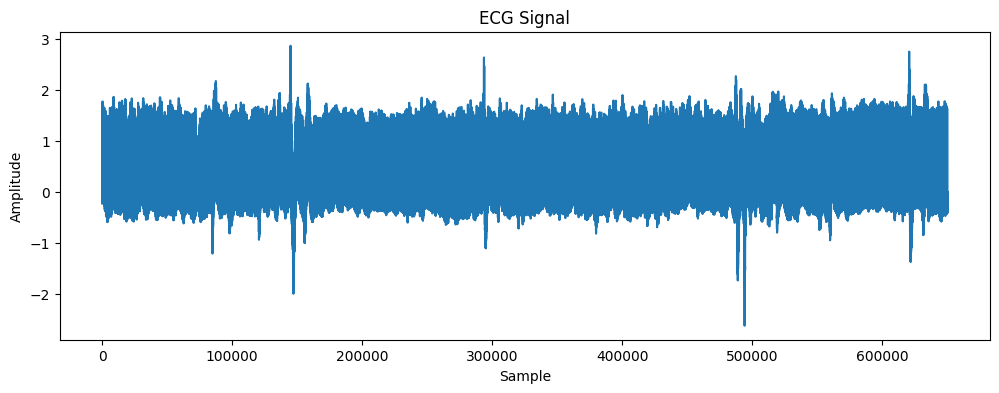

In [6]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [8]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [9]:
sign

(array([ 0.06880988,  0.05863463,  0.04446525, ...,  0.12512235,
         0.05933081, -0.00973522]),
 array([ 0.06865198,  0.05914625,  0.04453136, ...,  0.12498698,
         0.05928064, -0.00923027]),
 array([[0.06880988],
        [0.06880988],
        [0.05863463],
        ...,
        [0.18163472],
        [0.12512235],
        [0.05933081]]),
 array([[ 0.05863463],
        [ 0.04446525],
        [ 0.02671308],
        ...,
        [ 0.05933081],
        [-0.00973522],
        [-0.00973522]]),
 array([[ 0.05863463],
        [ 0.05863463],
        [ 0.04446525],
        ...,
        [ 0.12512235],
        [ 0.05933081],
        [-0.00973522]]))

In [10]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# Fungsi untuk menghitung Signal-to-Noise Ratio (SNR)
def calculate_snr(clean_data, denoised_data):
    noise = clean_data - denoised_data
    signal_power = np.sum(clean_data ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [12]:
# Membangun model Deep LSTM Autoencoder
def build_model(window_size):
    model = Sequential()

    # Encoder
    model.add(LSTM(64, activation='relu', input_shape=(window_size, 1), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))

    # Decoder
    model.add(RepeatVector(window_size))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer='adam', loss='mse')

    return model

In [13]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

In [14]:
result_snr = []
result_rmse = []
list_denoised_data = []
i = 1

# Menginisialisasi hyperparameters
window_size = 1
epochs = 100
batch_size = 128

for train_index, test_index in kfold.split(sign):
    # Print index data train dan test
    print("Train: ", train_index, "Test: ", test_index)

    # Mendapatkan data train dan test
    train_data, test_data = sign[train_index], sign[test_index]

    # Reshape data train dan test
    train_data = np.reshape(train_data, (train_data.shape[0], window_size, 1))
    test_data = np.reshape(test_data, (test_data.shape[0], window_size, 1))

    # Membangun model
    model = build_model(window_size)
    
    # Menambahkan Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Melatih model
    model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(test_data, test_data), callbacks=[early_stopping])

    # Menggunakan model untuk denoising data
    denoised_data = model.predict(test_data)

    # Menghitung sinyal asli
    asli = np.max(test_data, axis=1)

    # Menghitung sinyal noise
    noise = asli - np.max(denoised_data, axis=1)

    # Menghitung SNR
    snr = 10 * np.log10(np.sum(asli ** 2) / np.sum(noise ** 2))

    # Menghitung RMSE
    rmse = np.sqrt(mean_squared_error(asli, np.max(denoised_data, axis=1)))

    # Menampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    list_denoised_data.append(denoised_data)
    i += 1

Train:  [     1      2      3 ... 162496 162497 162498] Test:  [     0      4     12 ... 162488 162493 162499]
Epoch 1/100
1016/1016 [==============================] - 8s 4ms/step - loss: 0.0110 - val_loss: 1.0643e-05
Epoch 2/100
1016/1016 [==============================] - 4s 4ms/step - loss: 4.5094e-06 - val_loss: 4.2241e-06
Epoch 3/100
1016/1016 [==============================] - 4s 4ms/step - loss: 2.7626e-06 - val_loss: 2.2017e-06
Epoch 4/100
1016/1016 [==============================] - 4s 4ms/step - loss: 2.3511e-06 - val_loss: 1.4193e-06
Epoch 5/100
1016/1016 [==============================] - 4s 4ms/step - loss: 1.9655e-06 - val_loss: 1.1347e-06
Epoch 6/100
1016/1016 [==============================] - 4s 4ms/step - loss: 2.2767e-06 - val_loss: 1.3407e-06
Epoch 7/100
1016/1016 [==============================] - 4s 4ms/step - loss: 2.9341e-06 - val_loss: 4.0945e-07
Epoch 8/100
1016/1016 [==============================] - 4s 4ms/step - loss: 1.2276e-06 - val_loss: 3.6370e-07
Epoch

In [15]:
k = 1
for i in range(len(result_snr)):
    print(f"Hasil SNR ke-{k}:", result_snr[i])
    k += 1

Hasil SNR ke-1: 62.23264984797912
Hasil SNR ke-2: 61.29781020476551
Hasil SNR ke-3: 64.97716525714492
Hasil SNR ke-4: 62.033961345203764
Hasil SNR ke-5: 65.21718167242572


In [16]:
k = 1
for i in range(len(result_rmse)):
    print(f"Hasil rmse ke-{k}:", result_rmse[i])
    k += 1

Hasil rmse ke-1: 0.0002677375217610708
Hasil rmse ke-2: 0.0002982781093872507
Hasil rmse ke-3: 0.00019415591492692662
Hasil rmse ke-4: 0.00027314639300124975
Hasil rmse ke-5: 0.0001896529527398531


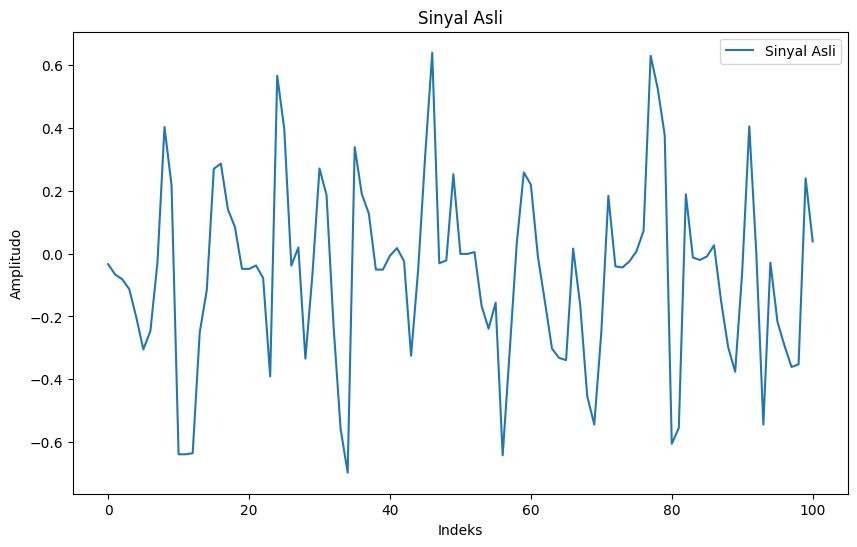

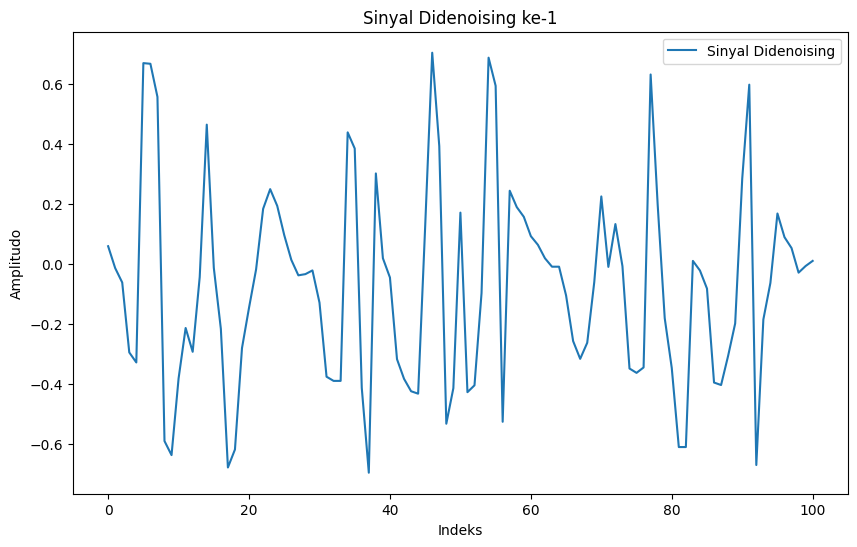

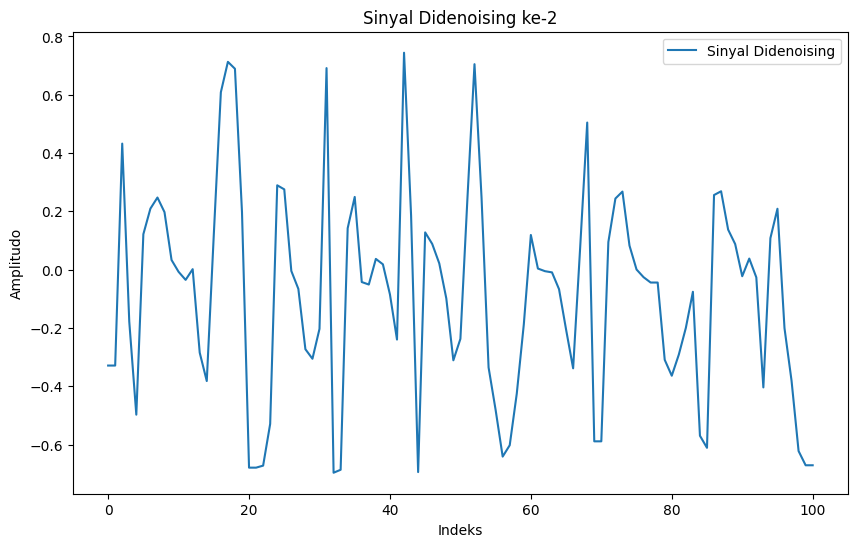

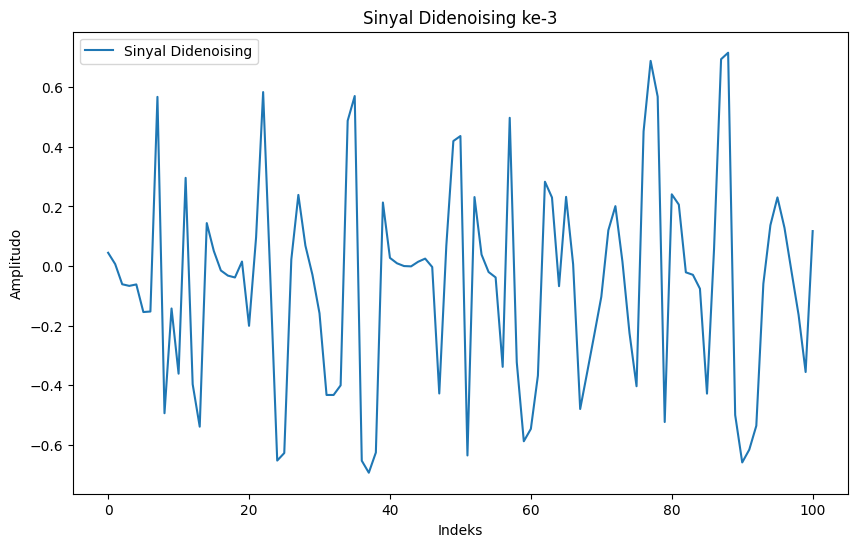

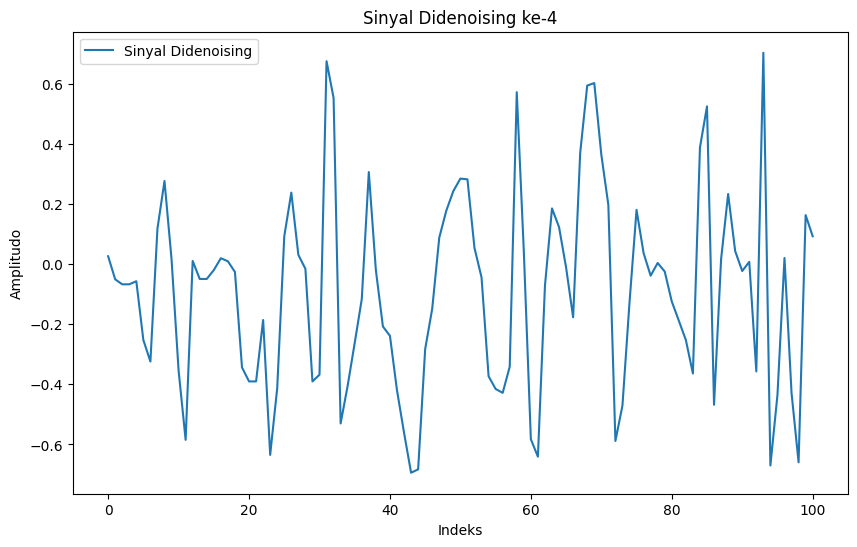

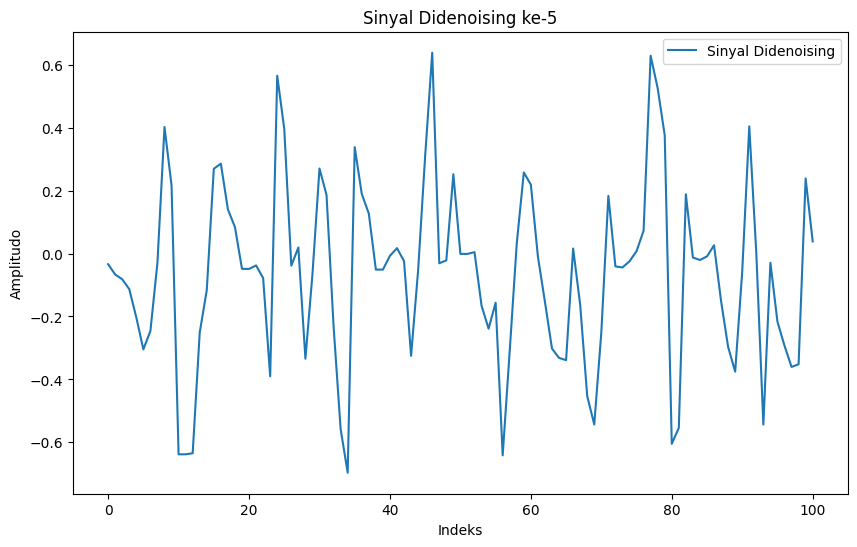

In [17]:
import matplotlib.pyplot as plt

# Memilih salah satu fold
fold_index = 0

# Mendapatkan sinyal asli dan sinyal yang telah didenoising dari fold yang dipilih
asli = np.max(test_data, axis=1)


# Menampilkan plot sinyal asli
plt.figure(figsize=(10, 6))
plt.plot(asli[0:101], label='Sinyal Asli')
plt.xlabel('Indeks')
plt.ylabel('Amplitudo')
plt.title('Sinyal Asli')
plt.legend()
plt.show()

k = 1
for i in range(len(list_denoised_data)):
    denoised = np.max(list_denoised_data[i], axis=1)
    # Menampilkan plot sinyal yang telah didenoising
    plt.figure(figsize=(10, 6))
    plt.plot(denoised[0:101], label='Sinyal Didenoising')
    plt.xlabel('Indeks')
    plt.ylabel('Amplitudo')
    plt.title(f'Sinyal Didenoising ke-{k}')
    plt.legend()
    plt.show()
    k += 1

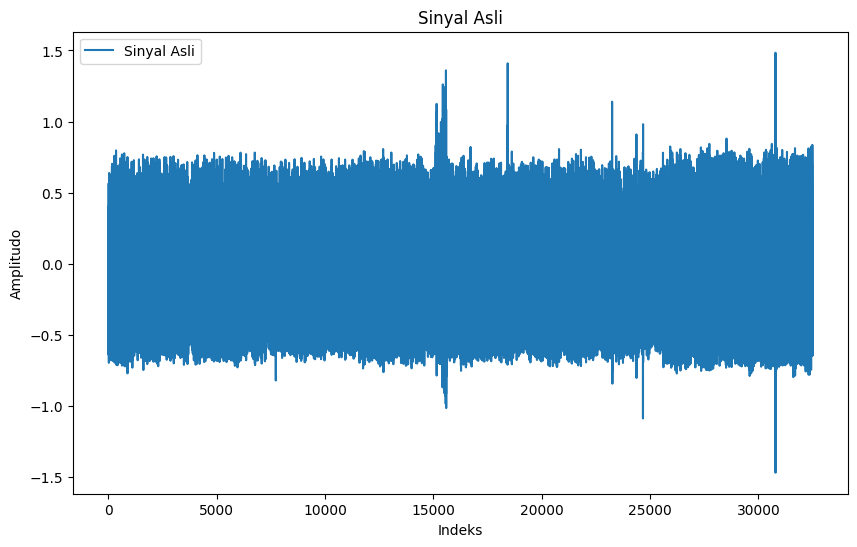

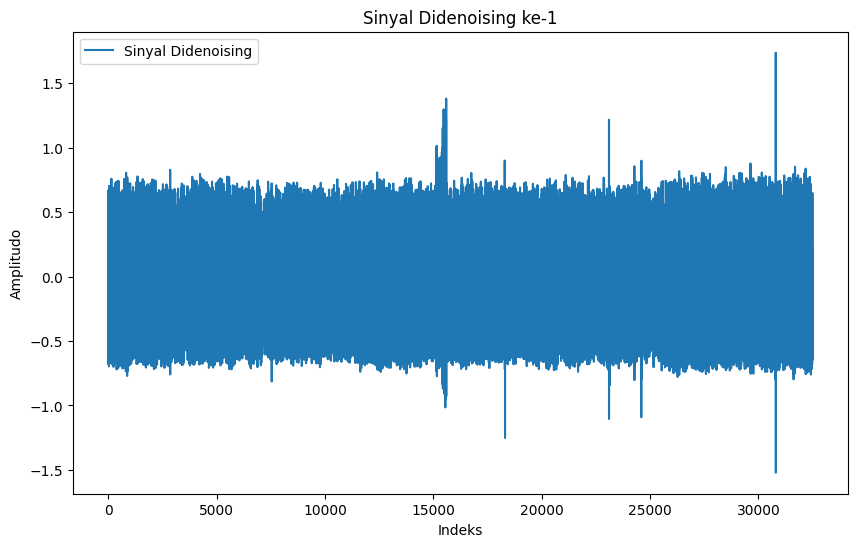

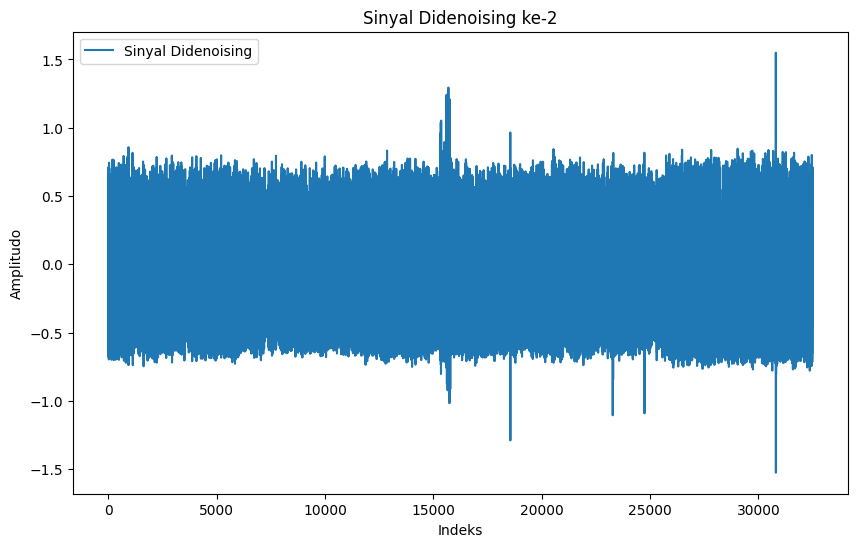

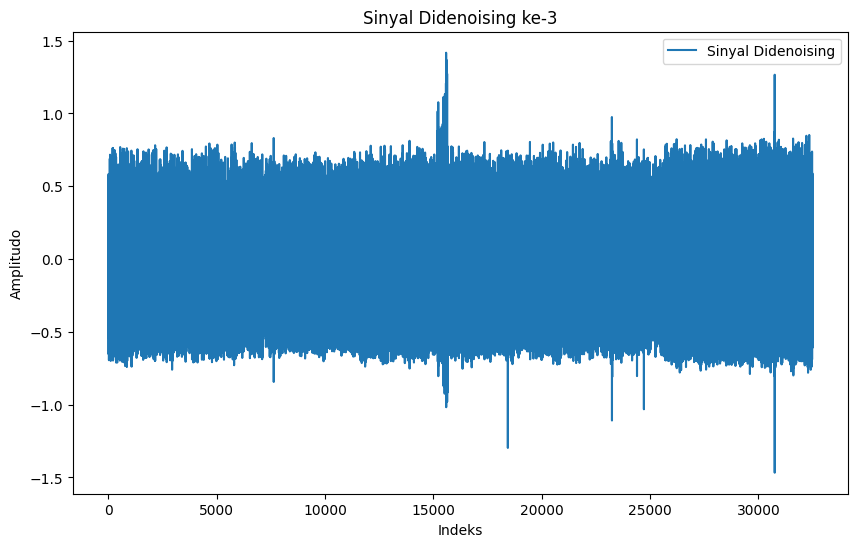

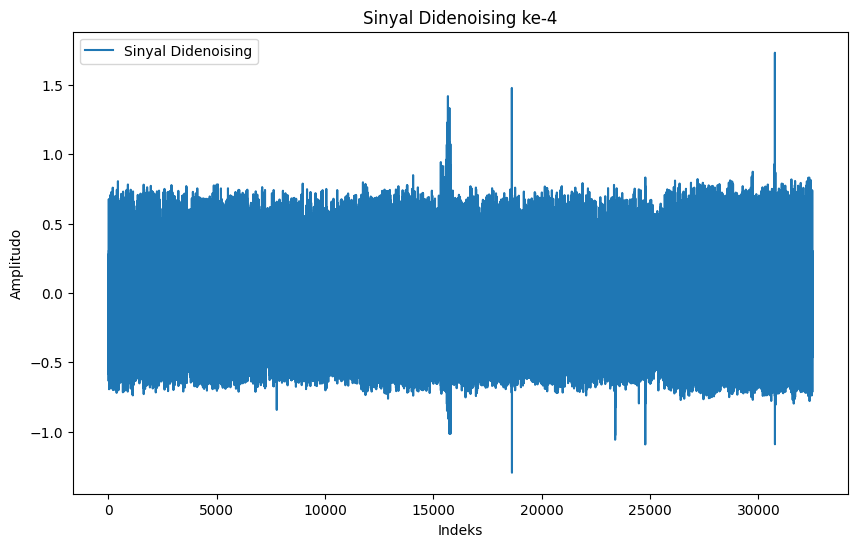

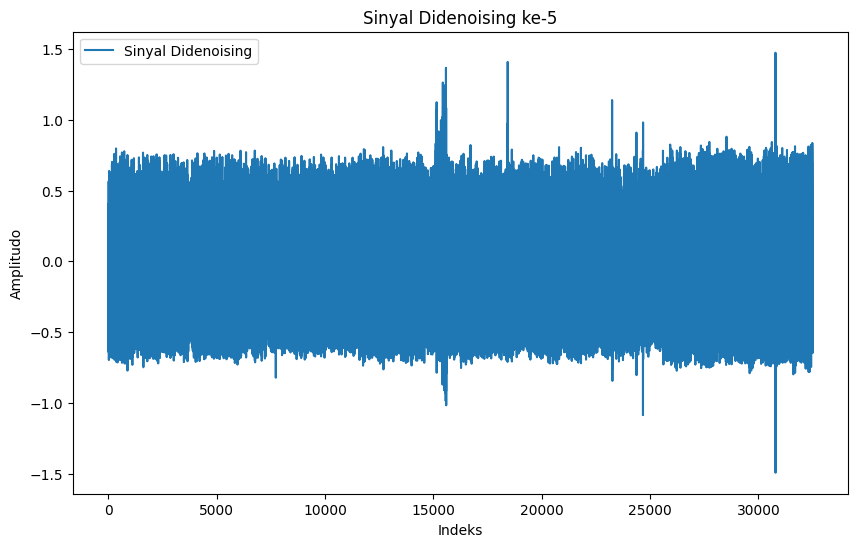

In [18]:
import matplotlib.pyplot as plt

# Memilih salah satu fold
fold_index = 0

# Mendapatkan sinyal asli dan sinyal yang telah didenoising dari fold yang dipilih
asli = np.max(test_data, axis=1)


# Menampilkan plot sinyal asli
plt.figure(figsize=(10, 6))
plt.plot(asli, label='Sinyal Asli')
plt.xlabel('Indeks')
plt.ylabel('Amplitudo')
plt.title('Sinyal Asli')
plt.legend()
plt.show()

k = 1
for i in range(len(list_denoised_data)):
    denoised = np.max(list_denoised_data[i], axis=1)
    # Menampilkan plot sinyal yang telah didenoising
    plt.figure(figsize=(10, 6))
    plt.plot(denoised, label='Sinyal Didenoising')
    plt.xlabel('Indeks')
    plt.ylabel('Amplitudo')
    plt.title(f'Sinyal Didenoising ke-{k}')
    plt.legend()
    plt.show()
    k += 1